In [ ]:
#pip install numpy pandas matplotlib scikit-learn tensorflow yfinance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
#use python39 python 3.9.12

In this project, I leveraged advanced machine learning techniques to build a Transformer-based model for financial time series forecasting, focusing on predicting the price movements of an equity ETF (AAPL). By utilizing multi-head attention layers, the model captures complex temporal dependencies and interactions across multiple input features such as 'Open', 'High', 'Low', 'Close', and 'Volume', alongside the stock's daily returns. To preprocess the data, I employed MinMax scaling to normalize both the feature set and the target variable, ensuring the model receives data in an optimal range for convergence. I utilized a custom time-series dataset creation pipeline to frame the past 60 days of data as input sequences for prediction, split into training and testing sets using a non-randomized, chronological approach to avoid data leakage. The model architecture includes layers of multi-head attention, feed-forward neural networks, and layer normalization to enhance feature extraction and stability. The model was trained using the Adam optimizer with a fine-tuned learning rate and early stopping to prevent overfitting. Throughout training, I monitored performance through loss metrics, visualized training progress, and evaluated model accuracy using metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE), while conducting inverse transformations to convert predictions back to original price scale for comparison. This project demonstrates my ability to apply cutting-edge deep learning techniques in quantitative finance to forecast market behavior and generate actionable insights for financial decision-making.

In [75]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [76]:


# Load ETF data 
data = yf.download('AAPL', start="2010-01-01", end="2023-01-01")




[*********************100%***********************]  1 of 1 completed


In [77]:

features = data[['Open', 'High', 'Low', 'Close', 'Volume']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(features)


# Prepare dataset with multiple features
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i])
        y.append(data[i, 3])  # Predict the Close price
    return np.array(X), np.array(y)



data['Returns'] = data['Close'].pct_change().fillna(0)
scaled_returns = scaler.fit_transform(data[['Returns']].values)



In [78]:
print(data.head())  # Check the first few rows
print(data.columns)  # Check the column names


Price          Close      High       Low      Open     Volume   Returns
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL          
Date                                                                   
2010-01-04  6.447411  6.462173  6.398304  6.429937  493729600  0.000000
2010-01-05  6.458559  6.495012  6.424515  6.465187  601904800  0.001729
2010-01-06  6.355827  6.484167  6.349199  6.458559  552160000 -0.015906
2010-01-07  6.344077  6.386857  6.297983  6.379325  477131200 -0.001849
2010-01-08  6.386254  6.386857  6.298285  6.335641  447610800  0.006648
MultiIndex([(  'Close', 'AAPL'),
            (   'High', 'AAPL'),
            (    'Low', 'AAPL'),
            (   'Open', 'AAPL'),
            ( 'Volume', 'AAPL'),
            ('Returns',     '')],
           names=['Price', 'Ticker'])


In [91]:
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.models import Model

def transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    #Dense Projection to Match Embedding Dimensions
    dense_projection = Dense(128, activation='relu')(inputs)  # Increase projection dimension to 128

    #Multi-Head Attention Block
    attn_output = MultiHeadAttention(num_heads=8, key_dim=128)(dense_projection, dense_projection)
    attn_output = Dropout(0.3)(attn_output)  # Increase dropout for regularization
    attn_output = LayerNormalization(epsilon=1e-6)(dense_projection + attn_output)  # Residual connection

    #Feed-Forward Neural Network (FFN)
    ffn_output = Dense(256, activation='relu')(attn_output)  # Increase FFN size for more complexity
    ffn_output = Dense(128, activation='relu')(ffn_output)
    ffn_output = Dropout(0.3)(ffn_output)  # Increase dropout
    ffn_output = LayerNormalization(epsilon=1e-6)(attn_output + ffn_output)  # Residual connection

    #Add Additional Transformer Block
    #Another layer of multi-head attention and FFN
    attn_output_2 = MultiHeadAttention(num_heads=8, key_dim=128)(ffn_output, ffn_output)
    attn_output_2 = Dropout(0.3)(attn_output_2)
    attn_output_2 = LayerNormalization(epsilon=1e-6)(ffn_output + attn_output_2)

    ffn_output_2 = Dense(256, activation='relu')(attn_output_2)
    ffn_output_2 = Dense(128, activation='relu')(ffn_output_2)
    ffn_output_2 = Dropout(0.3)(ffn_output_2)
    final_output = LayerNormalization(epsilon=1e-6)(attn_output_2 + ffn_output_2)

    #output layer for Regression
    outputs = Dense(1, activation='linear')(final_output)  # Linear activation for regression

   
    model = Model(inputs=inputs, outputs=outputs)
    return model




Shape of X: (3212, 60, 5)
Shape of y: (3212, 1)
Shape of X_train: (2569, 60, 5)
Shape of X_test: (643, 60, 5)
Shape of y_train: (2569, 1)
Shape of y_test: (643, 1)
Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - loss: 0.4064 - mean_absolute_error: 0.4759 - val_loss: 0.1886 - val_mean_absolute_error: 0.4199
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - loss: 0.0544 - mean_absolute_error: 0.1844 - val_loss: 0.1576 - val_mean_absolute_error: 0.3824
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - loss: 0.0270 - mean_absolute_error: 0.1298 - val_loss: 0.1296 - val_mean_absolute_error: 0.3462
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - loss: 0.0159 - mean_absolute_error: 0.0996 - val_loss: 0.0977 - val_mean_absolute_error: 0.2970
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - loss: 0.0102 - mean_absolute_error: 0.0797 - val_loss: 0.0882 - val_mean_absolute_error: 0.2822
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - loss: 0.0070 - mean_

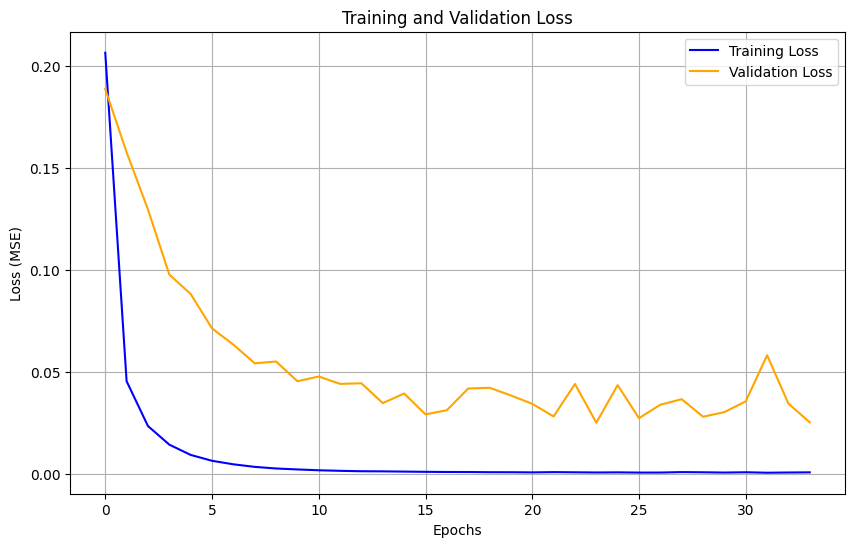

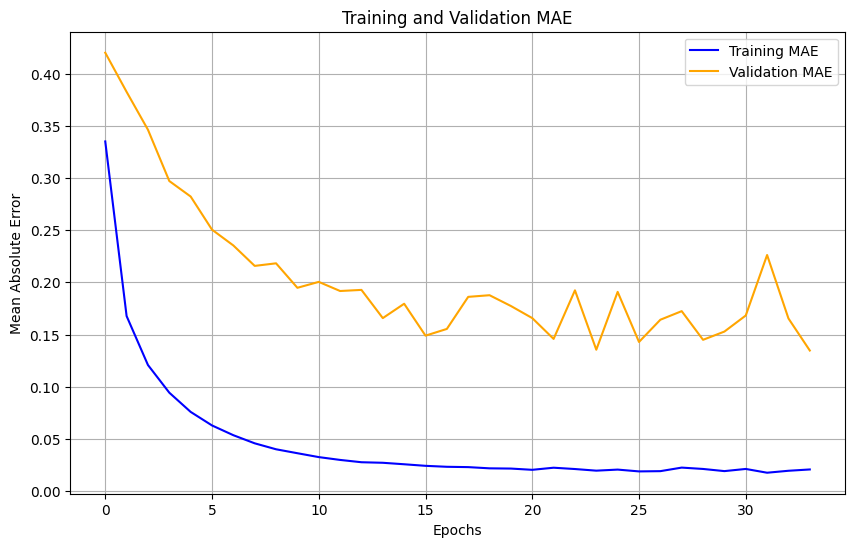

In [93]:

# Define time_step and scale features
time_step = 60  # Use the last 60 days for prediction
features = data[['Open', 'High', 'Low', 'Close', 'Volume']].values  # Use multiple features

# Define scalers
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale features
scaled_features = feature_scaler.fit_transform(features)

# Scale target ('Close' column)
target = features[:, 3].reshape(-1, 1)  # Extract 'Close' column
scaled_target = target_scaler.fit_transform(target)

# Create dataset
def create_dataset(data, target, time_step):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i])  # Use past 'time_step' days
        y.append(target[i])  # Use the scaled 'Close' price
    return np.array(X), np.array(y)

# Generate X and y
X, y = create_dataset(scaled_features, scaled_target, time_step)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Debugging shapes to confirm consistency
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Build Transformer model
model = transformer_model((X_train.shape[1], X_train.shape[2]))  # time_step, features

# Compile the model with regression-specific metrics
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mean_squared_error',  # Loss is MSE
    metrics=['mean_absolute_error']  # Use MAE as an additional metric
)

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Predictions
predicted_prices = model.predict(X_test)

# Debugging shapes of predictions
print(f"Shape of predicted_prices before reshaping: {predicted_prices.shape}")

# Reshape y_test and predicted_prices for evaluation
y_test = y_test.reshape(-1, 1)  # Ensure y_test is 2D
predicted_prices = predicted_prices.reshape(-1, 1)  # Ensure predicted_prices is 2D

# Align lengths if there's mismatch
min_len = min(len(y_test), len(predicted_prices))
y_test = y_test[:min_len]
predicted_prices = predicted_prices[:min_len]

# Debugging shapes after alignment
print(f"Final Shape of y_test: {y_test.shape}")
print(f"Final Shape of predicted_prices: {predicted_prices.shape}")

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test, predicted_prices))
mae = mean_absolute_error(y_test, predicted_prices)
r2 = r2_score(y_test, predicted_prices)

# Print Evaluation Metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² (Coefficient of Determination): {r2}")

# Plot Training and Validation Loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Plot Training and Validation MAE
def plot_mae(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mean_absolute_error'], label='Training MAE', color='blue')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(history)
plot_mae(history)


In [99]:
# Print Evaluation Metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² (Coefficient of Determination): {r2}")

Root Mean Squared Error (RMSE): 0.33794985242156894
Mean Absolute Error (MAE): 0.31757847109889725
R² (Coefficient of Determination): -6.844876625869586


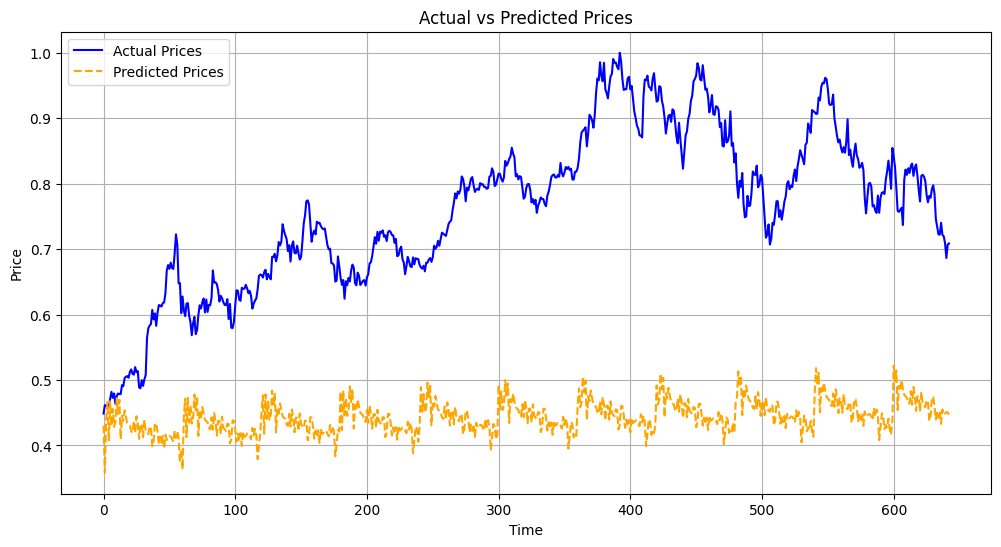

In [98]:
#Plot actual vs predicted prices
def plot_actual_vs_predicted(y_actual, y_pred):
    # Ensure both arrays are the same size
    min_len = min(len(y_actual), len(y_pred))
    y_actual = y_actual[:min_len]
    y_pred = y_pred[:min_len]

    plt.figure(figsize=(12, 6))
    plt.plot(y_actual, label='Actual Prices', color='blue')
    plt.plot(y_pred, label='Predicted Prices', linestyle='--', color='orange')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Actual vs Predicted Prices')
    plt.legend()
    plt.grid()
    plt.show()

# Align test and predicted data
y_test_actual = y_test.reshape(-1)  # Flatten to 1D
y_pred_actual = predicted_prices.reshape(-1)  # Flatten to 1D 


plot_actual_vs_predicted(y_test_actual, y_pred_actual)
